In [1]:
import utils
import processing as pr
from tqdm.autonotebook import tqdm

In [2]:
from sklearn.neighbors import NearestNeighbors

In [3]:
import matplotlib.pyplot as plt

In [4]:
import math
import numpy as np
import tensorflow as tf

In [5]:
from pyod.models.ecod import ECOD
from pyod.models.pca import PCA

In [6]:
import utils
import processing as pr

In [7]:
dataloader = pr.data_loader()

train_set, test_set, label_set = dataloader.MSL()

train_set, test_set = dataloader.min_max(train_set, test_set)

train_set_overlap = dataloader.window_overlap(train_set,100,0)
test_set_overlap = dataloader.window_overlap(test_set,100,0)

trainer = utils.trainer()

trainer.init_trainset(train_set_overlap)

trainer.build_ae()

trainer.train(50,256)

label_set, score_set = trainer.ROC_score(test_set_overlap,test_set,label_set, 0, name="test")

Reconstruction error at epoch 49: 0.7646
total loss at epoch 49: 0.7646
----------------  scoring  ------------------


100%|██████████| 43/43 [00:01<00:00, 37.96it/s]


--------------- reconstructing  ----------------


In [9]:
gt = label_set

In [10]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

In [11]:
f_best = 0
precision_best = 0
recall_best = 0
accuracy_best = 0
best_thr1 = 0

In [12]:
max = np.max(score_set)
min = np.min(score_set)
length = (max-min)/200

In [13]:
for i in tqdm(range(100)):
    thresh = min + i*(max-min)/100
    pred = (score_set > thresh).astype(int)
    anomaly_state = False
    for i in range(len(gt)):
        if gt[i] == 1 and pred[i] == 1 and not anomaly_state:
            anomaly_state = True
            for j in range(i, 0, -1):
                if gt[j] == 0:
                    break
                else:
                    if pred[j] == 0:
                        pred[j] = 1
            for j in range(i, len(gt)):
                if gt[j] == 0:
                    break
                else:
                    if pred[j] == 0:
                        pred[j] = 1
        elif gt[i] == 0:
            anomaly_state = False
        if anomaly_state:
            pred[i] = 1
    accuracy = accuracy_score(gt, pred)
    precision, recall, f_score, support = precision_recall_fscore_support(gt, pred,
                                                                            average='binary')
    if f_score > f_best:
        accuracy_best = accuracy
        f_best = f_score
        precision_best = precision
        recall_best = recall
        best_thr1 = thresh

100%|██████████| 100/100 [00:00<00:00, 266.41it/s]


In [14]:
print(
    "Accuracy : {:0.4f}, Precision : {:0.4f}, Recall : {:0.4f}, F-score : {:0.4f} ".format(
        accuracy_best, precision_best,
        recall_best, f_best))

Accuracy : 0.8658, Precision : 0.5358, Recall : 0.5127, F-score : 0.5240 


In [15]:
print(best_thr1)

0.1098729161884814


In [16]:
f_best = 0
precision_best = 0
recall_best = 0
accuracy_best = 0
best_thr = 0

In [17]:
for i in tqdm(range(100)):
    thresh = best_thr1 - (max-min)/200 + i*(max-min)/10000
    pred = (score_set > thresh).astype(int)
    anomaly_state = False
    for i in range(len(gt)):
        if gt[i] == 1 and pred[i] == 1 and not anomaly_state:
            anomaly_state = True
            for j in range(i, 0, -1):
                if gt[j] == 0:
                    break
                else:
                    if pred[j] == 0:
                        pred[j] = 1
            for j in range(i, len(gt)):
                if gt[j] == 0:
                    break
                else:
                    if pred[j] == 0:
                        pred[j] = 1
        elif gt[i] == 0:
            anomaly_state = False
        if anomaly_state:
            pred[i] = 1
    accuracy = accuracy_score(gt, pred)
    precision, recall, f_score, support = precision_recall_fscore_support(gt, pred,
                                                                            average='binary')
    if f_score > f_best:
        accuracy_best = accuracy
        f_best = f_score
        precision_best = precision
        recall_best = recall
        best_thr = thresh

100%|██████████| 100/100 [00:00<00:00, 276.83it/s]


In [18]:
print(
    "Accuracy : {:0.4f}, Precision : {:0.4f}, Recall : {:0.4f}, F-score : {:0.4f} ".format(
        accuracy_best, precision_best,
        recall_best, f_best))

Accuracy : 0.8942, Precision : 0.6758, Recall : 0.5111, F-score : 0.5820 


In [19]:
print(best_thr)

0.19436273695296896


In [20]:
from sklearn.metrics import roc_curve
from sklearn import metrics

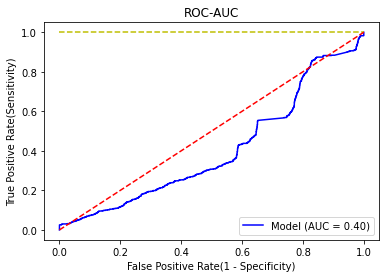

In [21]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(label_set, score_set)
roc_auc = metrics.roc_auc_score(label_set, score_set)
plt.title('ROC-AUC')
plt.xlabel('False Positive Rate(1 - Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')

plt.plot(false_positive_rate, true_positive_rate, 'b', label='Model (AUC = %0.2f)'% roc_auc)
plt.plot([0,1],[1,1],'y--')
plt.plot([0,1],[0,1],'r--')

plt.legend(loc='lower right')
plt.show()